# Modeling

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

np.random.seed(42)

Using TensorFlow backend.


In [2]:
train = pd.read_csv('./data/new_train.csv')
test = pd.read_csv('./data/new_test.csv')
labels = pd.read_csv('./data/train_labels.csv')

In [3]:
acc = labels[['game_session', 'accuracy_group']]
trainlab = train.merge(acc, on = 'game_session')

In [4]:
trainlab.drop(columns=['Unnamed: 0', 
                       'installation_id',
                       'game_time_s', 
                       'step_time',
                      'total_game_sessions',
                      'total_game_time',
                      'game_correct',
                      'game_incorrect',
                      'test_correct',
                      'test_incorrect',
                      'new_game',
                      'got_instructions',
                      'instruction_time',
                      'assessment_time',
                      'game_session'], inplace = True)

## FEATURE NOTES
1. We might have data leakage with the current cumulative calculation (it shouldn't include the correct/incorrect answers for the current game session but I think it does)
2. We might want to weight certain features more (or make combination features?) Ex. prior time spent on assessments might be more meaningful; the game/assessment scores from the last game or last three games; the ratio of time spent in the last world they were in before taking an assessment; the amount of time/number of times they got extra instructions)
3. Features we don't have that might be meaningful:
    - Whether or not this is a potentially noisy device (ex. more than 300 game sessions)
    - Slope of 'improvement' (how much faster the player is in the games, how their ratio of correct-incorrect responses has changed since the last game time)

### Balancing Classes
* I tried modeling with balanced classes, model did much worse on accuracy. Reverted modeling back to unbalanced version for now.

In [5]:
# Separate classes
df_0 = trainlab[trainlab['accuracy_group']==0]
df_1 = trainlab[trainlab['accuracy_group']==1]
df_2 = trainlab[trainlab['accuracy_group']==2]
df_3 = trainlab[trainlab['accuracy_group']==3]

print("df0 shape:", df_0.shape)
print("df1 shape:", df_1.shape)
print("df2 shape:", df_2.shape)
print("df3 shape:", df_3.shape)

df0 shape: (4229, 45)
df1 shape: (2411, 45)
df2 shape: (2205, 45)
df3 shape: (8845, 45)


### Train/Test/Split

In [6]:
X = trainlab.drop(columns = ['accuracy_group'])
y = trainlab['accuracy_group']

## to use balanced classes
# X = trainlab_bal.drop(columns = ['accuracy_group'])
# y = trainlab_bal['accuracy_group']


In [7]:
y.value_counts(normalize = True)

3    0.500000
0    0.239062
1    0.136292
2    0.124647
Name: accuracy_group, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [9]:
y_train.value_counts(normalize = True)

3    0.499962
0    0.239089
1    0.136278
2    0.124670
Name: accuracy_group, dtype: float64

In [10]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (13267,)
y_test shape: (4423,)


### Scaling

In [11]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

## Sequential Neural Network

1. Using the base information created above without much regard to balanced classes offers learning only in the training data and actually starts to hurt the validation data.
2. Need to set-up features that will help incrementally grow the validation data.
3. Potentially rebalancing the classes using Synthetic data will offer new insight.
4. The features attached to the Neural network are arbitary right now and can be update quickly when stronger data is collected, or current data is refined.

In [12]:
X_train_ss.shape

(13267, 44)

In [13]:
# one hot encode the classes
y_train_hot = to_categorical(y_train, num_classes=4, dtype='int32')

Train on 10613 samples, validate on 2654 samples
Epoch 1/100
10613/10613 [==============================] - 6s 539us/step - loss: 1.2019 - accuracy: 0.5105 - val_loss: 1.1519 - val_accuracy: 0.5237
Epoch 2/100
10613/10613 [==============================] - 5s 516us/step - loss: 1.1744 - accuracy: 0.5223 - val_loss: 1.1434 - val_accuracy: 0.5354
Epoch 3/100
10613/10613 [==============================] - 6s 544us/step - loss: 1.1624 - accuracy: 0.5260 - val_loss: 1.1467 - val_accuracy: 0.5339
Epoch 4/100
10613/10613 [==============================] - 5s 497us/step - loss: 1.1600 - accuracy: 0.5289 - val_loss: 1.1394 - val_accuracy: 0.5324
Epoch 5/100
10613/10613 [==============================] - 5s 503us/step - loss: 1.1563 - accuracy: 0.5303 - val_loss: 1.1438 - val_accuracy: 0.5403
Epoch 6/100
10613/10613 [==============================] - 5s 507us/step - loss: 1.1500 - accuracy: 0.5342 - val_loss: 1.1448 - val_accuracy: 0.5275
Epoch 7/100
10613/10613 [==============================] 

10613/10613 [==============================] - 5s 490us/step - loss: 1.0442 - accuracy: 0.5701 - val_loss: 1.1822 - val_accuracy: 0.5362
Epoch 56/100
10613/10613 [==============================] - 5s 485us/step - loss: 1.0425 - accuracy: 0.5734 - val_loss: 1.1857 - val_accuracy: 0.5381
Epoch 57/100
10613/10613 [==============================] - 5s 487us/step - loss: 1.0411 - accuracy: 0.5711 - val_loss: 1.2050 - val_accuracy: 0.5328
Epoch 58/100
10613/10613 [==============================] - 5s 484us/step - loss: 1.0396 - accuracy: 0.5690 - val_loss: 1.2169 - val_accuracy: 0.5396
Epoch 59/100
10613/10613 [==============================] - 5s 502us/step - loss: 1.0307 - accuracy: 0.5704 - val_loss: 1.2190 - val_accuracy: 0.5339
Epoch 60/100
10613/10613 [==============================] - 6s 543us/step - loss: 1.0313 - accuracy: 0.5703 - val_loss: 1.2203 - val_accuracy: 0.5384
Epoch 61/100
10613/10613 [==============================] - 5s 500us/step - loss: 1.0277 - accuracy: 0.5743 - val

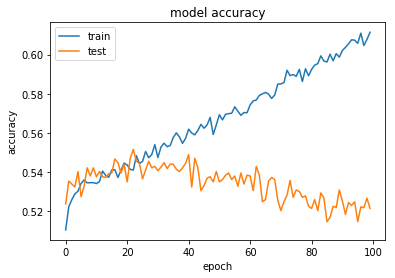

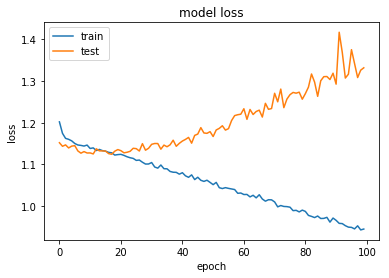

In [14]:
# Basic Pipeline for a Neueral Network.  The number of neurons was picked with no specific reasons
def seq_nn(X, y):
    
    """
    X (array): data
    y (array): one hot encoded target
    """
    
    model = Sequential()
    model.add(Dense(250, input_dim=44, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))

    # categorical entropy for the softmax
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # No specific reason for number of epochs or batch size.
    history = model.fit(x=X, y=y,
                        epochs=100,
                        batch_size=20,
                        validation_split=0.2,
                        )

    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
seq_nn(X_train_ss, y_train_hot)

### RESAMPLING THE DATA
 - Incorporating synthetic data using SMOTE to help rebalance the class which creates data with noise by using nearest neighbors to create the data.


In [15]:
sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_sample(X_train_ss, y_train_hot)

In [16]:
print(X_train_res.shape, y_train_res.shape)

(26532, 44) (26532, 4)


Train on 21225 samples, validate on 5307 samples
Epoch 1/100
21225/21225 [==============================] - 11s 536us/step - loss: 1.2410 - accuracy: 0.4210 - val_loss: 2.4288 - val_accuracy: 0.0156
Epoch 2/100
21225/21225 [==============================] - 10s 493us/step - loss: 1.2125 - accuracy: 0.4379 - val_loss: 2.4031 - val_accuracy: 0.0187
Epoch 3/100
21225/21225 [==============================] - 11s 495us/step - loss: 1.2017 - accuracy: 0.4473 - val_loss: 2.5419 - val_accuracy: 0.0164
Epoch 4/100
21225/21225 [==============================] - 11s 500us/step - loss: 1.1950 - accuracy: 0.4538 - val_loss: 2.3788 - val_accuracy: 0.0277
Epoch 5/100
21225/21225 [==============================] - 11s 500us/step - loss: 1.1885 - accuracy: 0.4582 - val_loss: 2.2929 - val_accuracy: 0.0168
Epoch 6/100
21225/21225 [==============================] - 11s 503us/step - loss: 1.1809 - accuracy: 0.4637 - val_loss: 2.3460 - val_accuracy: 0.0188
Epoch 7/100
21225/21225 [==========================

Epoch 55/100
21225/21225 [==============================] - 10s 486us/step - loss: 0.9192 - accuracy: 0.6122 - val_loss: 2.0610 - val_accuracy: 0.0842
Epoch 56/100
21225/21225 [==============================] - 10s 473us/step - loss: 0.9167 - accuracy: 0.6119 - val_loss: 2.0079 - val_accuracy: 0.0735
Epoch 57/100
21225/21225 [==============================] - 10s 468us/step - loss: 0.9134 - accuracy: 0.6165 - val_loss: 2.0392 - val_accuracy: 0.0863
Epoch 58/100
21225/21225 [==============================] - 11s 531us/step - loss: 0.9044 - accuracy: 0.6167 - val_loss: 1.9004 - val_accuracy: 0.1104
Epoch 59/100
21225/21225 [==============================] - 11s 517us/step - loss: 0.9093 - accuracy: 0.6191 - val_loss: 1.9087 - val_accuracy: 0.1083
Epoch 60/100
21225/21225 [==============================] - 11s 520us/step - loss: 0.8996 - accuracy: 0.6197 - val_loss: 1.9189 - val_accuracy: 0.1031
Epoch 61/100
21225/21225 [==============================] - 11s 533us/step - loss: 0.8954 - ac

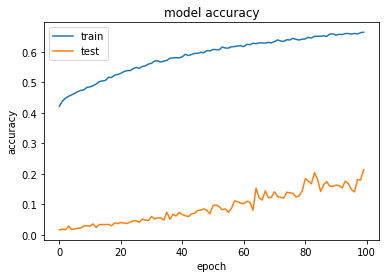

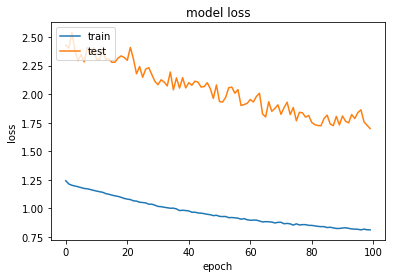

In [17]:
seq_nn(X_train_res, y_train_res)

In [18]:
bs = BorderlineSMOTE(random_state=42)
X_train_bs, y_train_bs = bs.fit_resample(X_train_ss, y_train_hot)

Train on 21225 samples, validate on 5307 samples
Epoch 1/100
21225/21225 [==============================] - 11s 530us/step - loss: 1.2378 - accuracy: 0.4309 - val_loss: 2.2311 - val_accuracy: 0.0239
Epoch 2/100
21225/21225 [==============================] - 11s 506us/step - loss: 1.2107 - accuracy: 0.4501 - val_loss: 2.5453 - val_accuracy: 0.0194
Epoch 3/100
21225/21225 [==============================] - 11s 517us/step - loss: 1.2017 - accuracy: 0.4541 - val_loss: 2.2940 - val_accuracy: 0.0298
Epoch 4/100
21225/21225 [==============================] - 11s 510us/step - loss: 1.1912 - accuracy: 0.4618 - val_loss: 2.3053 - val_accuracy: 0.0247
Epoch 5/100
21225/21225 [==============================] - 11s 512us/step - loss: 1.1867 - accuracy: 0.4671 - val_loss: 2.2474 - val_accuracy: 0.0350
Epoch 6/100
21225/21225 [==============================] - 11s 510us/step - loss: 1.1783 - accuracy: 0.4704 - val_loss: 2.3629 - val_accuracy: 0.0249
Epoch 7/100
21225/21225 [==========================

Epoch 55/100
21225/21225 [==============================] - 11s 503us/step - loss: 0.8950 - accuracy: 0.6271 - val_loss: 1.8358 - val_accuracy: 0.1246
Epoch 56/100
21225/21225 [==============================] - 11s 503us/step - loss: 0.8877 - accuracy: 0.6279 - val_loss: 1.7293 - val_accuracy: 0.1315
Epoch 57/100
21225/21225 [==============================] - 11s 533us/step - loss: 0.8877 - accuracy: 0.6277 - val_loss: 1.8605 - val_accuracy: 0.1082
Epoch 58/100
21225/21225 [==============================] - 11s 526us/step - loss: 0.8841 - accuracy: 0.6289 - val_loss: 1.7482 - val_accuracy: 0.1581
Epoch 59/100
21225/21225 [==============================] - 11s 510us/step - loss: 0.8751 - accuracy: 0.6356 - val_loss: 1.8523 - val_accuracy: 0.1074
Epoch 60/100
21225/21225 [==============================] - 11s 521us/step - loss: 0.8796 - accuracy: 0.6359 - val_loss: 1.7291 - val_accuracy: 0.1455
Epoch 61/100
21225/21225 [==============================] - 12s 543us/step - loss: 0.8729 - ac

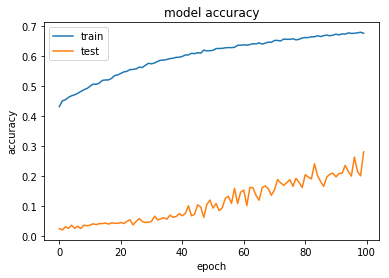

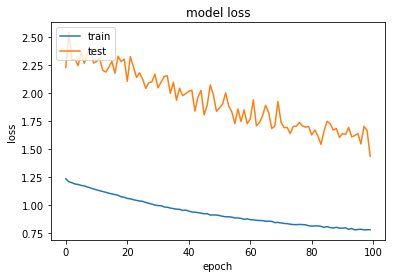

In [19]:
seq_nn(X_train_bs, y_train_bs)

### Neural Network Notes
- Resampling and adding synthetic data gives much more reasonable results for the validation data and training data
- Training data seems to be learning from the data given.  Offers hope that there is a correct answer
- The large gap between the training and the validation suggests overfitting to the training data.
- Need to clean the data better and do more feature creation
